In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'nvda' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'goog': '08/16/2004'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-14,535.549988,523.099976,523.520020,532.349976,6753900.0,532.349976,-0.016867,0.023800,0.022708,0.021145,-0.004239,-1
2020-12-15,538.559998,527.469971,537.590027,534.419983,4837100.0,534.419983,0.005897,0.021025,0.003888,0.019601,0.000312,-1
2020-12-16,537.489990,528.500000,536.900024,529.700012,5577900.0,529.700012,0.013410,0.017010,-0.008832,0.011320,0.004827,1
2020-12-17,535.179993,527.140015,534.669983,533.650024,5784600.0,533.650024,0.001908,0.015252,0.007457,0.011327,0.005676,-1
2020-12-18,536.200012,522.820007,535.159973,530.880005,8551600.0,530.880005,0.007998,0.025592,-0.005191,0.012360,0.004006,1
2020-12-21,534.799988,518.700012,522.989990,533.289978,7558300.0,533.289978,-0.019694,0.031039,0.004540,0.006993,0.000372,-1
2020-12-22,533.489990,522.159973,532.770020,531.130005,4639500.0,531.130005,0.003078,0.021698,-0.004050,0.006895,-0.001215,-1
2020-12-23,531.000000,520.200012,530.239990,520.369995,4478600.0,520.369995,0.018614,0.020761,-0.020259,0.010825,-0.003501,1
2020-12-24,525.299988,517.549988,521.489990,519.750000,2447100.0,519.750000,0.003337,0.014974,-0.001191,0.009206,-0.005230,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
# va.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

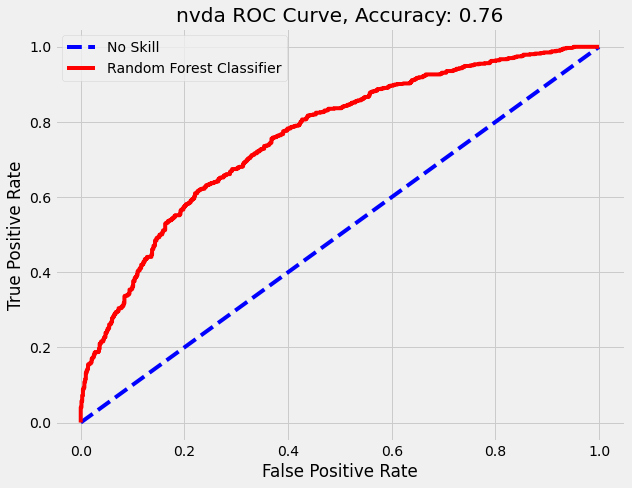

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

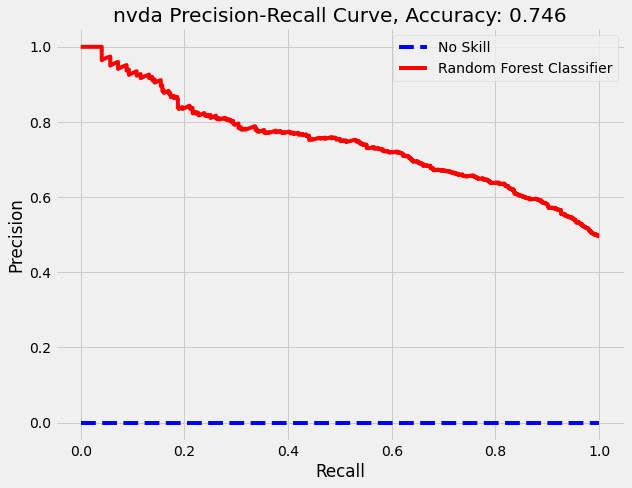

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

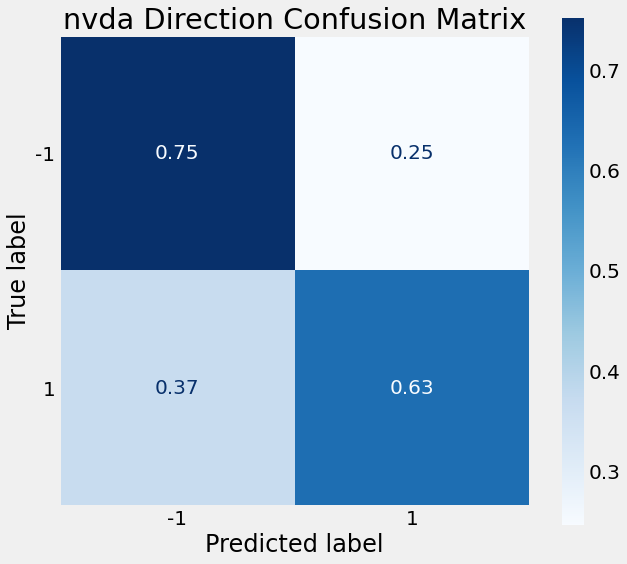

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7069809610154125'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          5.225000e+02
Low           5.105300e+02
Open          5.225000e+02
Close         5.160000e+02
Volume        5.310400e+06
Adj Close     5.160000e+02
oc            1.244019e-02
hl            2.344623e-02
adj          -7.215007e-03
5stdev_adj    9.248351e-03
5sma_adj     -5.635173e-03
direction    -1.000000e+00
Name: 2020-12-28 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.012440
hl            0.023446
5stdev_adj    0.009248
5sma_adj     -0.005635
Name: 2020-12-28 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy nvda


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-21,534.799988,518.700012,522.98999,533.289978,7558300.0,533.289978,-0.019694,0.031039,0.004540,0.006993,0.000372,-1,-1,0.004050
2020-12-22,533.489990,522.159973,532.77002,531.130005,4639500.0,531.130005,0.003078,0.021698,-0.004050,0.006895,-0.001215,-1,1,-0.020259
2020-12-23,531.000000,520.200012,530.23999,520.369995,4478600.0,520.369995,0.018614,0.020761,-0.020259,0.010825,-0.003501,1,1,-0.001191
2020-12-24,525.299988,517.549988,521.48999,519.750000,2447100.0,519.750000,0.003337,0.014974,-0.001191,0.009206,-0.005230,-1,1,-0.007215
2020-12-28,522.500000,510.529999,522.50000,516.000000,5310400.0,516.000000,0.012440,0.023446,-0.007215,0.009248,-0.005635,-1,1,0.000925


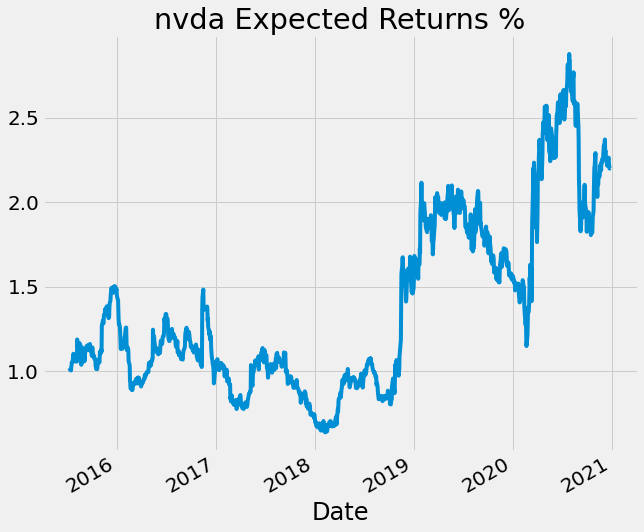

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

10.465896382962825

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

104.44958908851085

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/